In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader  # Import for dataloader, load data into system
from torchvision import datasets, transforms  #MNist Dataset
import time    # length of duration of our training,testing, etc.
import sys     # acts as system library and it is mandatory for any python code
import matplotlib.pyplot as plt


In [2]:
# ---- Hyperparameters for defining this simple FCNN Model ----
Batch_size = 64    # we can take any batch size based on the capability of our RAM and particularly GPU RAM.
Learning_rate = 0.001
Num_epochs = 5     # mnist DATASET IS VERY EASY FOR THIS NEURAL NETWORK THATS WHY I USE 5 EPOCHS, that is sufficient.

In [3]:
# ---- DEVICE Definition ---
# This line automatically checks if a CUDA - enabled GPU is available.
# if it is, the DEVICE is set to ' cuda', enabling fast GPU acceleration.
# otherwise, it defaults to ' cpu', which uses the system's processor.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"usung device: {device}")

usung device: cpu


## Data Loading and Preprocessing


The MNIST dataset consists 60,000 training and 10,000 testing samples of 28 x 28 grayscale(single channel) images of digits (0-9). We need to transform the data to PyTorch tensors and normalize the pixel values to the range [0,1].
- Whenever we work with any kind of data in neural network or any machine learning models, we require to transform the raw data.
- Very basic pre-processing are required, like normalization that should be done to any data we are feeding to our model.
-

In [4]:
# 1. Define Transformation
transform = transforms.Compose([
    transforms.ToTensor(),   # Converts image to tensor "human see as (H, W, C) -> torch see as (C, H, W)"",
                             # because channel gets the priority, channel wise operations done by torch.
    transforms.Normalize((0.1307,), (0.3081,))   # 1st one is Mean and other is standard deviationof the Gaussian function for Standard normalization for MNIST
])

# 2. Download and Load Datasets
# NOTE: If running for the first time, PyTorch will download the dataset.
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 57.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]


In [5]:
# create Dataloaders

train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)     # here shuffle=true because we do shuffling in training to feed random data
test_loader = DataLoader(test_dataset, batch_size = Batch_size, shuffle = False)  # here shuffle=False, we don't need shuffle here

print(f"training_samples: {len(train_dataset)}")
print(f"testing_samples: {len(test_dataset)}")

training_samples: 60000
testing_samples: 10000


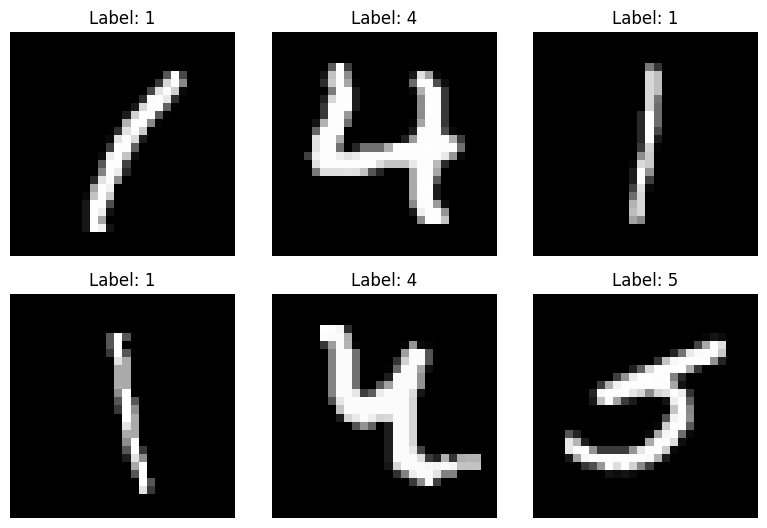

In [6]:
# Create a figure
plt.figure(figsize=(8, 8 ))

for i in range(6) :              # Plot 6 images from 60,000
  # 1. Get a random image and its label
  sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
  img, label = train_dataset[sample_idx]


  # 2. Reshape/Squeeze the image
  # MNIST is automatically gave you (1, 28, 28) matrix, but matplotlib only takes 2 Dimensional thats why
  # this squeeze function automatically finds where the one valued dimension is there and squeeze
  img = img.squeeze()

  # 3. Plot
  plt.subplot(3, 3, i+1)
  plt.imshow(img, cmap='gray')
  plt.title(f"Label: {label}")
  plt.axis('off')

plt.tight_layout()
plt.show()

### Fully Connected Neural Network ($FCNN$)

The FCNN (also known as a multilayer Perceptron or MLP) ia the most basic architecture. it is great for tabular (1D) data and we need to convert our image or 2D matrix into 1D vector.


### Formatting Data and Labels

We can flatten this array into a vector of **28 X 28 = 784** numbers. it doesn't matter how we flatten the array, as long as we're consistent between images. From this perspective, the MNIST images are just a bunch of points in a 784-dimensional vector space. The data should always be of the format (Number of data points, data point dimension). In this case the training data will be of format **60,000 X 784.**

In [7]:
# Make a FCNN class
class FCNN(nn.Module):       # This is the SuperClass of all Neural Network

# Two functions are mandetory for each in the class, one is "__init__ function" and other "forward" function
# __init__ is create for model architecture
  def __init__(self, input_size=784, num_classes=10) :
    super(FCNN, self).__init__()
    self.fc1 = nn.Linear(input_size, 128)  # Input layer, 128 Neurons
    self.fc2 = nn.Linear(128, 64)          # Middle layer
    self.fc3 = nn.Linear(64, num_classes)  # Output layer

# Final output is given by forward function
  def forward(self, x) :
    # Flatten the input: (Batch, 1, 28, 28) -> (Batch, 784)
    x = x.view(x.size(0), -1)   # We just minus the 1 to crush the channel dimension
    x = F.relu(self.fc1(x))     # 784 X 128 weight matrix will be multiplied by x + 128 biases
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


# This is only for count the number of parameters we define
def count_parameters(model) :
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Models defined.")

Models defined.


## Training and Testing Functions

In [8]:
def train_model(model, train_loader, optimizer, epoch) :
  # Runs a single training epoch.
  model.train()      # say model to train
  running_loss = 0.0

  for batch_idx, (data, target) in enumerate(train_loader) :
    # Crucially, send data and target to the selected device
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)        # Compute mathemathical inside no of layers we define

    # Use Cross-Entropy loss for classification
    loss = F.cross_entropy(output, target)    # y=target, yhat=output here
    loss.backward()              # Backpropagation
    optimizer.step()             # Weight optimizer new Ws layer by layer

    running_loss += loss.item()

  # this line say information how the training going on
  avg_loss = running_loss / len(train_loader)
  print(f"Epoch {epoch} | Training Loss: {avg_loss:.4f}")


In [9]:
def test_model(model, test_loader):
  # Evaluate the model on the test set.
  model.eval()      # it is necessary to call, no optimization here, nothing is changed here in test
  test_loss = 0
  correct = 0

  with torch.no_grad():       # No gradients are calculated during testing
    for data, target in test_loader:
      # Crucially, send data and target to the selected device
      data, target = data.to(device), target.to(device)
      output = model(data)

      # Sum up batch loss
      test_loss += F.cross_entropy(output, target, reduction='sum').item()

      # Get the index of the max log-probability (the prediction), which label giving the highest probability
      pred = output.argmax(dim=1, keepdim=True)    # Label predictor
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss/= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)

  print(f"\nTest set: Avg Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}")
  return accuracy

### Execution - FCNN

In [10]:
print("=========================================")
print("1. Starting FCNN Training (Baseline)")
print("=========================================")

# Explicitly passing input_size=784 and num_classes=10 to match MNIST data
fcnn_model = FCNN(input_size=784, num_classes=10).to(device)
fcnn_optimizer = optim.Adam(fcnn_model.parameters(), lr=Learning_rate)    # Adam optimizer function use here

print(f"FCNN Parameters: {count_parameters(fcnn_model)}")
fcnn_start_time = time.time()

# Here the training happens till the number of epochs
for epoch in range(1, Num_epochs + 1):
  train_model(fcnn_model, train_loader, fcnn_optimizer, epoch)

fcnn_test_accuracy = test_model(fcnn_model, test_loader)

fcnn_total_time = time.time() - fcnn_start_time
print(f"FCNN Total Training Time: {fcnn_total_time:.2f} seconds")

1. Starting FCNN Training (Baseline)
FCNN Parameters: 109386
Epoch 1 | Training Loss: 0.2749
Epoch 2 | Training Loss: 0.1127
Epoch 3 | Training Loss: 0.0799
Epoch 4 | Training Loss: 0.0611
Epoch 5 | Training Loss: 0.0497

Test set: Avg Loss: 0.0879, Accuracy: 9744/10000
FCNN Total Training Time: 74.86 seconds


### Saving and reloading a model to test in future

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
fcnn_model = FCNN(input_size=784, num_classes=10).to(device)
fcnn_optimizer = optim.Adam(fcnn_model.parameters(), lr=Learning_rate)

print(f"FCNN Parameters: {count_parameters(fcnn_model)}")
fcnn_start_time = time.time()

# --- TRAINING LOOP ---
for epoch in range(1, Num_epochs + 1):
  train_model(fcnn_model, train_loader, fcnn_optimizer, epoch)

fcnn_total_time = time.time() - fcnn_start_time
print(f"FCNN Total Training Time: {fcnn_total_time:.2f}seconds")

# --- Save TO Drive ---
# Define the filename
import os
# --- Save TO Drive ---

save_path = "/content/drive/MyDrive/models"

os.makedirs(save_path, exist_ok=True)

model_file = os.path.join(save_path, "fcnn_model.pth")

torch.save(fcnn_model.state_dict(), model_file)

print(f"Model saved at:", {model_file})

FCNN Parameters: 109386
Epoch 1 | Training Loss: 0.2732
Epoch 2 | Training Loss: 0.1137
Epoch 3 | Training Loss: 0.0793
Epoch 4 | Training Loss: 0.0605
Epoch 5 | Training Loss: 0.0505
FCNN Total Training Time: 74.70seconds
Model saved at: {'/content/drive/MyDrive/models/fcnn_model.pth'}


In [13]:
print(fcnn_model)

FCNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [14]:
!ls

data  drive  sample_data


In [15]:
torch.save(fcnn_model.state_dict(), "fcnn_model.pth")

Anytime once the model is saved we can test it anytime as many as we want to test it. And as many as ways we can.

Re-initialize the model structure

now, has happened only the architecture, the shell of the model has been created, that there will be three layers, the input layers dimension will be 784, number of classes will be 10.


**So There comes how to test a model.**


let's reinitialize the model

In [26]:
# 1. Re-initialize the model structure
reloaded_model = FCNN(input_size=784, num_classes=10).to(device)

# 2. Load the weights from Google Drive
model_file = "/content/drive/MyDrive/models/fcnn_model.pth"
reloaded_model.load_state_dict(torch.load(model_file))  # here reload the model, means whatever layers we have specified the structure
# we have created in this line. in each and every neuron, now the optimized parameters or the learned parameters will be loaded through this load-staked dictionary.

# Run The Test
fcnn_test_accuracy = test_model(reloaded_model, test_loader)
print(f"Reloade Model Accuracy: {fcnn_test_accuracy:2f}%")


Test set: Avg Loss: 0.0829, Accuracy: 9741/10000
Reloade Model Accuracy: 97.410000%


In [27]:
%cd /content/mnist-classification-pytorch

/content/mnist-classification-pytorch
